# PTML Project

Group :
- paul.messeant
- paul.renoux
- matthieu.schlienger
- nikoloz.chaduneli

### Imports

## Part 2 : Unsupervised learning

*For unsupervised learning the evaluation of the quality of the result will be different than for supervised learning. It could be the inertia, distorsion, KL divergence, etc.*


In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# string manipulation libs
import re
import nltk
from nltk.corpus import stopwords

# viz libs
import matplotlib.pyplot as plt
import seaborn as sns

### Processing

In [72]:
df = pd.read_csv('data2/tweets.csv', encoding='latin-1', nrows=5000, names=['tweet_id', 'date', 'no', 'user', 'text'])
df.head()

,tweet_id,date,no,user,text
0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [73]:
nltk.download('stopwords')
nltk.download('punkt')
stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\paulm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\paulm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Stopwords are a series of words that add no information to our model. We have to create a preprocess_text function that takes some text as input and returns a clean version of it. 

In [74]:
def preprocess_text(text: str, remove_stopwords: bool) -> str:
    """This utility function sanitizes a string by:
    - removing links
    - removing special characters
    - removing numbers
    - removing stopwords
    - transforming in lowercase
    - removing excessive whitespaces
    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords
    Returns:
        str: the cleaned text
    """
    niw = ["got", "get", "go"] + stopwords.words("english")

    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    if remove_stopwords:
        # 1. tokenize
        tokens = nltk.word_tokenize(text)
        # 2. check if stopword
        tokens = [w for w in tokens if not w.lower() in niw]
        # 3. join back together
        text = " ".join(tokens)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

In [75]:
df['cleaned'] = df['text'].apply(lambda x: preprocess_text(x, remove_stopwords=True))
df.head()

,tweet_id,date,no,user,text,cleaned
0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww bummer shoulda david carr thir...
0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dived many times ball managed save re...
0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feels itchy like fire
0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behaving mad see


The TF-IDF converts our tweets into a numerical format by bringing out specific terms, weighing very rare or very common terms differently in order to assign them a low score. The TF-IDF value increases proportionally to the number of times a word appears in a tweet and is offset by the number of tweets that contain that word.

In [76]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df['cleaned'])

KMeans is one of the most known and used unsupervised algorithms in data science and is used to group a set of data into a defined number of groups. The idea behind it is very simple: the algorithm initializes random positions (called centroids, the red, blue and green points in the screenshot below) in the vector plane and assigns the point to the nearest centroid. The algorithm calculates the average position of the points and moves the respective centroid to that position and updates the group to which each point belongs. The algorithm converges when all points are at the minimum distance from their respective centroid.

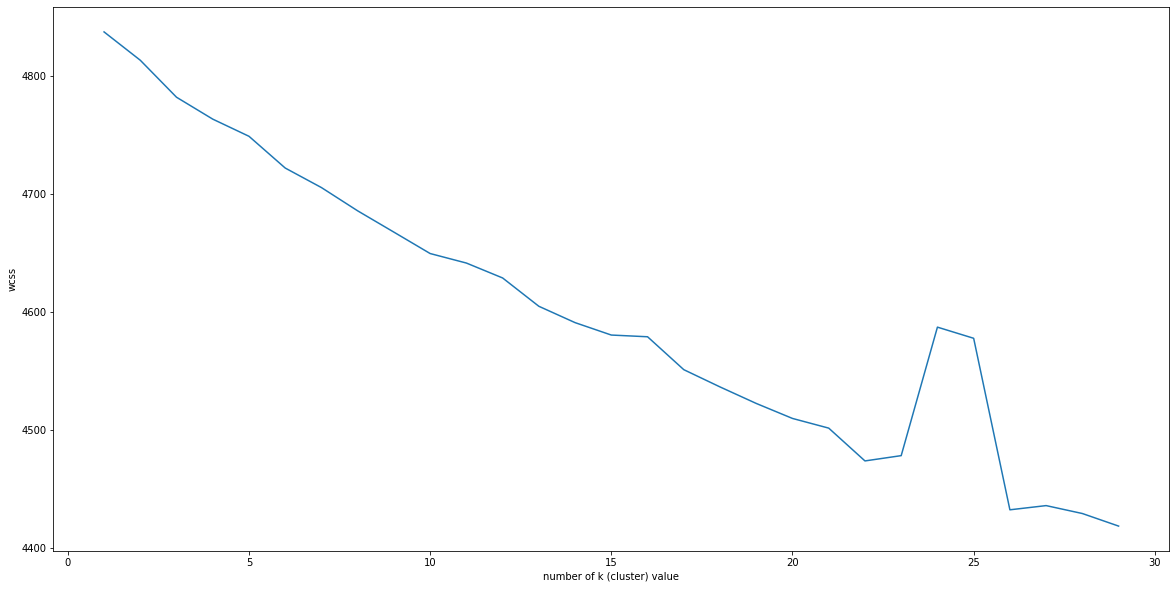

In [77]:
kms = []

for k in range(1,30):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    kms.append(kmeans.inertia_)

plt.figure(figsize=(20,10))
plt.plot(range(1,30),kms)
plt.xlabel("number of k (cluster) value")
plt.ylabel("wcss")
plt.show()

To find the optimal K for a dataset, use the Elbow method. We have to find the point where the decrease in inertia begins to slow. K=20 is the “elbow” of this graph. So we are going to use 20 clusters.

In [78]:
from sklearn.cluster import KMeans

# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=20, random_state=42)
# fit the model
kmeans.fit(X)
# store cluster labels in a variable
clusters = kmeans.labels_

PCA is a technique which reduces the dimensionality of a data set to an arbitrary number while preserving most of the information contained in it.

In [79]:
from sklearn.decomposition import PCA

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [80]:
df['cluster'] = clusters
df['x0'] = x0
df['x1'] = x1

We can see now which are the most relevant keywords for each centroid to observe patterns 

In [81]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0
hope,really,oh,twitter,good,day,sleep,going,sorry,miss

Cluster 1
bed,days,still,night,day,early,ready,ta,going,work

Cluster 2
work,lol,sounds,sleep,day,someone,feels,looks,feel,like

Cluster 3
call,cooking,wait,early,ugh,day,see,still,sick,hate

Cluster 4
makes,without,need,watching,time,day,kutner,oh,house,sad

Cluster 5
fun,bad,really,lol,dont,work,sleep,gon,wan,na

Cluster 6
going,day,really,though,im,cant,sleep,tired,see,still

Cluster 7
na,sold,morning,use,still,album,amp,back,like,quot

Cluster 8
last,well,long,another,school,early,going,day,tomorrow,time

Cluster 9
really,feel,even,sad,never,let,lol,dont,like,know

Cluster 10
home,today,yet,still,going,let,last,day,new,one

Cluster 11
feel,sick,ill,tomorrow,going,school,feeling,work,day,today

Cluster 12
yay,looking,find,tonight,job,well,think,gone,yet,new

Cluster 13
going,amp,ready,next,really,last,im,house,missing,week

Cluster 14
old,bed,im,sleep,really,dont,one,work,back,want

Cluster 15
sleep,coming,bed,wish,d

We can see for example that the Cluster 1 regroup routine's words 

In [82]:
cluster_map = {}
for i in range(0,20):
    cluster_map[i] = "group " + str(i)
df['cluster'] = df['cluster'].map(cluster_map)

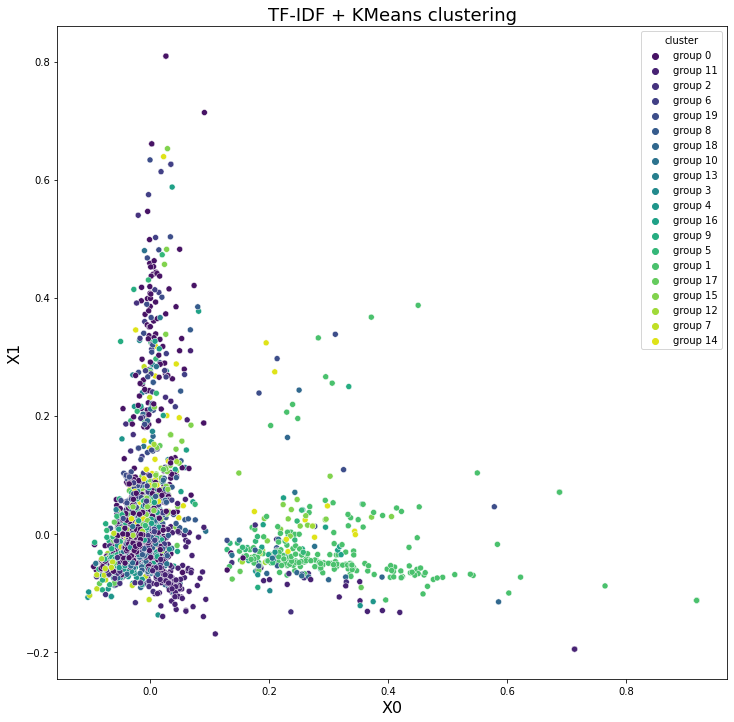

In [83]:
# set image size
plt.figure(figsize=(12, 12))
# set a title
plt.title("TF-IDF + KMeans clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()

As we can see, the clustering activity worked : the algorithm found groups. Some of them are almost similar because of their close pattern. Tweets are very random and common terms among some of these tweets which, when vectorized, obtain equal values for some dimensions.